# Estimating European Option Price Using Amplitude Estimation - Workshop

## Introduction and Background


In Finance models we are often interested in calculating the average of a function of a given probability distribution ($E[f(x)]$). The most popular method to estimate the average is Monte Carlo [[1](#MCMF)] due to its flexibility and ability to generically handle stochastic parameters.
Classical Monte Carlo methods, however, generally require extensive computational resources to provide an accurate estimation.
By leveraging the laws of quantum mechanics, a quantum computer may provide novel ways to solve computationally intensive financial problems, such as risk management, portfolio optimization, and option pricing.
The core quantum advantage of several of these applications is the Amplitude Estimation algorithm [[2](#AEA)] which can estimate a parameter with a
convergence rate of $\Omega(1/M^{2})$, compared to $\Omega(1/M)$ in the classical case, where $M$ is the number of Grover iterations in the quantum case and the number of the Monte Carlo samples in the classical case. This represents a theoretical quadratic speed-up of the quantum method over classical Monte Carlo methods!

### Option Pricing

An option is the possibility to buy (call) or sell (put) an item (or share) at a known price - the strike price (K), where the option has a maturity price (S).
The payoff function to describe for example a European call option will be:

$$f(S)=\
\Bigg\{\begin{array}{lr}
    0, & \text{when } K\geq S\\
    S - K, & \text{when } K < S\end{array}
$$

The maturity price is unknown. Therefore, it is expressed by a price distribution function, which may be any type of a distribution function.
For example a log-normal distribution: $\mathcal{ln}(S)\sim~\mathcal{N}(\mu,\sigma)$,
where $\mathcal{N}(\mu,\sigma)$ is the standard normal distribution with mean equal to $\mu$ and standard deviation equal to $\sigma$ .


#### To estimate the average option price using a quantum computer, we need to:

- Load the distribution, that is, discretize the distribution using $2^n$ points (n is the number of qubits) and truncate it.

- Implement the payoff function that is equal to zero if $S\leq{K}$ and increases linearly otherwise.
  The linear part is approximated in order to be properly loaded using $R_y$ rotations [[3](#QAR)].

- Evaluate the expected payoff using amplitude estimation.

The algorithmic framework is called Quantum Monte-Carlo Integration. For a basic example, see [QMCI](https://github.com/Classiq/classiq-library/blob/main/algorithms/amplitude_estimation/qmc_user_defined/qmc_user_defined.ipynb).
Here we use the same framework to estimate european call option, where the underlying asset distribution at the maturity data is modeled as log-normal distribution.

## Designing the Quantum Algorithm

In this workshop, we will collaboratively design a quantum algorithm to estimate the price of a European option.
This algorithm can be applied to real-world stock data, providing practical results and offering a potential speedup over the classical Monte Carlo method.
During the algorithm design process, you will explore state preparation and arithmetics, define Qstructs (quantum classes), and function calling using Classiq?

The code in the following section is incomplete, with missing parts that you need to fill in, indicated by "#TODO" in the code description. If you're unsure how to use a specific Classiq function, please refer to the [Classiq documentation](https://docs.classiq.io) and search for the required quantum function to find its corresponding documentation page.

### The Probability Distribution

We begin by creating the probability distribution. The distribution is describing the option underlying asset price at maturity date.
We will load a discrete version of the log-normal probability with $2^n$ points, when $\mu$ of the normal distribution is denoted by `mu`, $\sigma$ by `sigma` and $n$ is the number of qubits `num_qubits`. `K`, the strike price, is also chosen in this section.

In [51]:
num_qubits = 5
mu = 0.7
sigma = 0.13

K = 1.9

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import scipy


def get_log_normal_probabilities(mu_normal, sigma_normal, num_points):
    # TODO Define the log-normal mean (log_normal_mean), variance (log_normal_variance) and standard deviation (log_normal_stddev)
    ##### SOLUTION START ####
    log_normal_mean = np.exp(mu + sigma**2 / 2)
    log_normal_variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    log_normal_stddev = np.sqrt(log_normal_variance)
    ###### SOLUTION END #####

    # cutting the distribution 3 sigmas from the mean
    low = np.maximum(0, log_normal_mean - 3 * log_normal_stddev)
    high = log_normal_mean + 3 * log_normal_stddev
    print(log_normal_mean, log_normal_variance, log_normal_stddev, low, high)
    x = np.linspace(low, high, num_points)
    return x, scipy.stats.lognorm.pdf(x, s=sigma_normal, scale=np.exp(mu_normal))

2.030841014265948 0.07029323208790372 0.26512870853210846 1.2354548886696226 2.8262271398622736


Text(0.5, 1.0, 'Probability and Payoff vs. Asset Value')

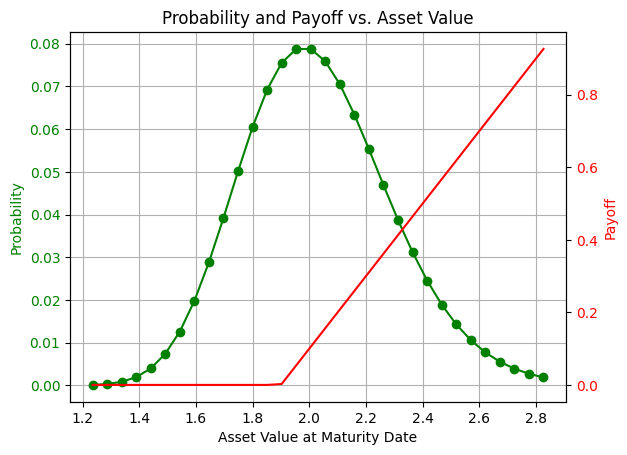

In [53]:
grid_points, probs = get_log_normal_probabilities(mu, sigma, 2**num_qubits)

# TODO normalize the probabilities
##### SOLUTION START ####
probs = (probs / np.sum(probs)).tolist()
###### SOLUTION END #####

fig, ax1 = plt.subplots()

# Plotting the log-normal probability function
ax1.plot(grid_points, probs, "go-", label="Probability")  # Green line with circles
ax1.tick_params(axis="y", labelcolor="g")
ax1.set_xlabel("Asset Value at Maturity Date")
ax1.set_ylabel("Probability", color="g")

# Creating a second y-axis for the payoff function  F= S-K
ax2 = ax1.twinx()
ax2.plot(grid_points, np.maximum(grid_points - K, 0), "r-", label="Payoff")  # Red line
ax2.set_ylabel("Payoff", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Adding grid and title
ax1.grid(True)
plt.title("Probability and Payoff vs. Asset Value")

#### Quantum Function for Distribution Loading

Here we use the general `inplace_prepare_state` [function](https://docs.classiq.io/latest/sdk-reference/?h=inplace_prepare_state#classiq.qmod.builtins.functions.inplace_prepare_int). The `inplace_prepare_state` function is applied instead of `prepare_state` when a state preparation needs to be repeatedly applied to the same previously initialized quantum variable.








We use the genreal purpose state preparation for simplicity. There are more efficient and scalable methods for preparing the required distribution, for example, see [[4](#GS)].

In [54]:
from classiq import *


# Loading the probabilities to a QNum variable named "asset"
@qfunc
def load_distribution(asset: QNum):
    # TODO load the probabilities you have prepared in the previous sections (Note: the probabilities need to be transformed to a list)
    ##### SOLUTION START ####
    inplace_prepare_state(probs, bound=0, target=asset)
    ###### SOLUTION END #####

### The Payoff Function

We now proceed to load the payoff function. Our end objective is to construct $U_{payoff}$, which satisfies:

 $$U_{payoff}|S\rangle|0\rangle = \sqrt{f(S)}|S\rangle|1\rangle + \sqrt{1-f(S)}|S\rangle|0\rangle$$
Where $\ket{S}$ is the quantum state of the maturity price $S$ (disregarding the prepared probability amplitudes for now) represented by a Qnum variable named 'asset' (see note), and the qubit state ($
\ket{0}$ on the LHS) is represented by the 'ind' variable, serving as the indicator qubit. 
Due to the structure of the European option price payoff function, it is easily observed that the state remains unchanged if the maturity price $S$ is less than the strike price $K$. For $S
\geq K$, on the other hand, a linear amplitude loading is applied to reflect the option's payoff.








*Note: in order to save qubits and depth, the register $|S\rangle_n$ will hold a value in the range $[0, 2^{n-1}]$, effectively "labeling" the asset values. The mapping from the label space to the asset value space (and vice-versa) will occur within the comparator and amplitude loading, using the following (classical) `scale`/`descale` functions correspondingly*

In [55]:
from classiq.qmod.symbolic import ceiling

# Calculating the size between steps
grid_step = (max(grid_points) - min(grid_points)) / (len(grid_points) - 1)


# Transforming from QNum label space to price space
def scale(val: QNum):
    # TODO write the transform of the QNum label value to the asset value (Clue: see next function)
    ##### SOLUTION START ####
    return val * grid_step + min(grid_points)
    ###### SOLUTION END #####


# Transforming from price space to QNum label space
def descale(val: int):
    return (val - min(grid_points)) / grid_step


# A function putting a control condition on the asset (maturity) price, checking if it is 'in the money' (meaning if it has crossed the strike price). if it is, payoff_linear is applied.
@qfunc
def payoff(asset: Const[QNum], ind: QBit):
    # TODO Put the correct code to apply this logic.
    # Use a controlled operation for checking that the asset is above the strike price
    # Call the payoff_linear function for the payoff part
    #### SOLUTION START ####
    # checking if asset price is 'in the money' - crossed the strike price
    control(asset >= ceiling(descale(K)), lambda: payoff_linear(asset, ind))
    ###### SOLUTION END #####

For the amplitude loading step, we use a general-purpose loading method utilizing the `*=` syntax. While the calculation is accurate, it is not scalable for large variable sizes.

There are more scalable methods, like the ones mentioned in [[4](#GS)], [[6](#RAINBOW)].

*See [Quantum Types](https://docs.classiq.io/latest/qmod-reference/language-reference/quantum-types/?h=qstruct#semantics) in documentation (under Qmod reference) for Qstruct definition

*Important: To ensure that the sum of all loaded amplitudes does not exceed 1, we normalize the payoff using a `scaling_factor`, which will later be multiplied during the post-processing stage.*

In [56]:
from classiq.qmod.symbolic import abs, sqrt

# Scaling the function by the maximal S-K value:
scaling_factor = max(grid_points) - K


# Amplitude Loading of the scaled payoff linear function to 'ind', for asset values that are 'in the money'. This is done using *= (Amplitude Encoding)[https://docs.classiq.io/latest/qmod-reference/language-reference/statements/amplitude-encoding-assignment/]
# We would like the probability of the indicator qubit to be proportional to the payoff function (the amplitude should be therefore a square-root of the scaled payoff function)
# P(ind=1) = |(scale(asset) - K) / scaling_factor|
@qfunc
def payoff_linear(asset: Const[QNum], ind: QBit):
    #### SOLUTION START ####
    ind *= sqrt(abs((scale(asset) - K) / scaling_factor))
    ###### SOLUTION END #####


# quantum function that loads the distribution and then operates the payoff function (prepares U_payoff)
@qfunc
def european_call_state_preparation(asset: QNum, ind: QBit):
    load_distribution(asset)
    payoff(asset, ind)

### Wrapping to an Amplitude Estimation model

After defining the probability distribution and the payoff function, we pack it into a `grover_operator`. Both stages completed so far contribute to the state preparation process that precedes the successive applications of the [Grover operator](https://docs.classiq.io/latest/explore/functions/qmod_library_reference/classiq_open_library/grover_operator/grover_operator/), an operator used to amplify the amplitudes of specific states corresponding to a desired output. 


A Grover operator consists of two components: a phase oracle, which is used to distinguish between 'good' state and 'bad' states, and a diffusion operator, which reflects the states about the mean axis (usually achieved by some state preparation successively followed by a reflection about the $\ket{0}$ state).
In our case, the oracle function $O_f=\ket{x} \rightarrow (-1)^{f(x)}\ket{x}$ is quite simple, and only needs to flip the sign when the indicator qubit is in the $
\ket{1}$ state (meaning $f(1)=1,\; f(0)=0$)

After the initial probability and payoff loading, iterations of the Grover operator are applied within the [Iterative Quantum Amplitude Estimation algorithm](https://github.com/Classiq/classiq-library/blob/main/algorithms/amplitude_estimation/quantum_counting/quantum_counting.ipynb) [[5](#IQAE)], which is a generalization of the Grover search algorithm, utilized for the estimation of the amplitude $a$ to arbitrary precision, given the state (now taking the prepared probability amplitudes into account):
$$
|\Psi\rangle = \sum_x|x\rangle[\sqrt{p(x)f(x)}|1\rangle_{ind} + \sqrt{p(x)(1-f(x))}|0\rangle_{ind}]=\sqrt{a}|\Psi_1\rangle + \sqrt{1-a}|\Psi_0\rangle
$$
Which approximates the expectation value of the payoff (after a post-processing step):
$$
a = \sum_xp(x)f(x) \approx E[f]_p
$$

In [57]:
# Defining the iterative quantum amplitude estimation algorithm

from classiq.applications.iqae.iqae import IQAE

# TODO set constrains to a maximal width of 25 qubits because of the limited resources of simulators
##### SOLUTION START ####
constraints = Constraints(max_width=25)
###### SOLUTION END #####

iqae = IQAE(
    state_prep_op=european_call_state_preparation,
    problem_vars_size=num_qubits,
    constraints=constraints,
    preferences=Preferences(optimization_level=1),
)

## Quantum program synthesis

After we finished the model design, we synthesize the model to a quantum program.

In [58]:
qprog = iqae.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2ys1ApWeTomdHj6K3roBIXQjCGW


## Quantum Program Execution

Finally, we execute with defined parameters for the accuracy of the amplitude estimation. This will affect the expected number of grover of repetitions within the execution, which is generally $O(\sqrt{N})$:

In [59]:
result = iqae.run(
    epsilon=0.05,
    alpha=0.01,  # desired error  # desired probability for error
)

#### Post processing
In order to get the expected payoff, we need to descale the measured amplitude by `scaling_factor`.

In [60]:
measured_payoff = result.estimation * scaling_factor
condidence_interval = np.array(result.confidence_interval) * scaling_factor

print("Measured Payoff:", measured_payoff)
print("Confidence Interval:", condidence_interval)

Measured Payoff: 0.1753896325820247
Confidence Interval: [0.17209738 0.17868189]


### Compare to the expected calculated payoff

In [61]:
expected_payoff = sum((grid_points - K) * (grid_points >= K) * probs)
print("Expected Payoff:", expected_payoff)

Expected Payoff: 0.17680663493930157


In [62]:
assert np.isclose(
    measured_payoff,
    expected_payoff,
    atol=10 * (condidence_interval[1] - condidence_interval[0]),
)

## References

<a name='MCMF'>[1]</a>: [Paul Glasserman, Monte Carlo Methods in Financial Engineering. Springer-Verlag New York, 2003, p. 596.](https://link.springer.com/book/10.1007/978-0-387-21617-1)

<br><a name='AEA'>[2]</a>: [Gilles Brassard, Peter Hoyer, Michele Mosca, and Alain Tapp, Quantum Amplitude Amplification and Estimation. Contemporary Mathematics 305 (2002)](https://arxiv.org/abs/quant-ph/0005055)

<br><a name='QAR'>[3]</a>: [ Nikitas Stamatopoulos, Daniel J. Egger, Yue Sun, Christa Zoufal, Raban Iten, Ning Shen, and Stefan Woerner, Option Pricing using Quantum Computers, Quantum 4, 291 (2020).
](https://arxiv.org/abs/1905.02666v5)

<br><a name='GS'>[4]</a>: [ Chakrabarti, Shouvanik, et al. "A threshold for quantum advantage in derivative pricing." Quantum 5 (2021): 463.](https://quantum-journal.org/papers/q-2021-06-01-463/)

<br><a name='IQAE'>[5]</a>: [Grinko, D., Gacon, J., Zoufal, C. et al. Iterative quantum amplitude estimation. npj Quantum Inf 7, 52 (2021)](https://doi.org/10.1038/s41534-021-00379-1)

<br><a name='RAINBOW'>[6]</a>: [Francesca Cibrario et al., Quantum Amplitude Loading for Rainbow Options Pricing. Preprint](https://arxiv.org/abs/2402.05574v2)